# Исследование продаж компьютерных игр

Из открытых источников доступны исторические данные о продажах игр, оценки пользователей и экспертов, жанры и платформы. Необходимо выявить определяющие успешность игры закономерности и для каждого из трех регионов (NA, Europe, JP) выбрать игры для рекламных кампаний.

In [1]:
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
import numpy as np
from scipy import stats as st
import warnings

In [2]:
games = pd.read_csv('C:\\Users\\yansa\\YP_Projects\\YP_DataSets\\SP4\\games.csv')

In [3]:
games.head()

,Name,Platform,Year_of_Release,Genre,NA_sales,EU_sales,JP_sales,Other_sales,Critic_Score,User_Score,Rating
0,Wii Sports,Wii,2006.0,Sports,41.36,28.96,3.77,8.45,76.0,8,E
1,Super Mario Bros.,NES,1985.0,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN
2,Mario Kart Wii,Wii,2008.0,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E
3,Wii Sports Resort,Wii,2009.0,Sports,15.61,10.93,3.28,2.95,80.0,8,E
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN


In [4]:
games.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Name             16713 non-null  object 
 1   Platform         16715 non-null  object 
 2   Year_of_Release  16446 non-null  float64
 3   Genre            16713 non-null  object 
 4   NA_sales         16715 non-null  float64
 5   EU_sales         16715 non-null  float64
 6   JP_sales         16715 non-null  float64
 7   Other_sales      16715 non-null  float64
 8   Critic_Score     8137 non-null   float64
 9   User_Score       10014 non-null  object 
 10  Rating           9949 non-null   object 
dtypes: float64(6), object(5)
memory usage: 1.4+ MB


In [5]:
games.describe()

,Year_of_Release,NA_sales,EU_sales,JP_sales,Other_sales,Critic_Score
count,16446.000000,16715.000000,16715.000000,16715.000000,16715.000000,8137.000000
mean,2006.484616,0.263377,0.145060,0.077617,0.047342,68.967679
std,5.877050,0.813604,0.503339,0.308853,0.186731,13.938165
min,1980.000000,0.000000,0.000000,0.000000,0.000000,13.000000
25%,2003.000000,0.000000,0.000000,0.000000,0.000000,60.000000
50%,2007.000000,0.080000,0.020000,0.000000,0.010000,71.000000
75%,2010.000000,0.240000,0.110000,0.040000,0.030000,79.000000
max,2016.000000,41.360000,28.960000,10.220000,10.570000,98.000000


In [6]:
display(games['Platform'].unique())
display(games['Genre'].unique())

array(['Wii', 'NES', 'GB', 'DS', 'X360', 'PS3', 'PS2', 'SNES', 'GBA',
       'PS4', '3DS', 'N64', 'PS', 'XB', 'PC', '2600', 'PSP', 'XOne',
       'WiiU', 'GC', 'GEN', 'DC', 'PSV', 'SAT', 'SCD', 'WS', 'NG', 'TG16',
       '3DO', 'GG', 'PCFX'], dtype=object)

array(['Sports', 'Platform', 'Racing', 'Role-Playing', 'Puzzle', 'Misc',
       'Shooter', 'Simulation', 'Action', 'Fighting', 'Adventure',
       'Strategy', nan], dtype=object)

В таблице присутствуют данные с 1980 до 2016 года. Плафтформы и жанры заполнены на первый взгляд корректно. 
В колонках c оценками и рейтингами много пропусков, также их надо перевести в числовой формат. 
Год выпуска нужно перести в формат дат.

### Предобработка данных

In [7]:
column_names = []
for i in games.columns:
    column_names.append(i.lower())
    
games.columns = column_names
games.columns

Index(['name', 'platform', 'year_of_release', 'genre', 'na_sales', 'eu_sales',
       'jp_sales', 'other_sales', 'critic_score', 'user_score', 'rating'],
      dtype='object')

In [8]:
games = games[games['name'].isna() == False]

In [9]:
games[games['year_of_release'].isna() == True][['name', 'year_of_release']]

,name,year_of_release
183,Madden NFL 2004,NaN
377,FIFA Soccer 2004,NaN
456,LEGO Batman: The Videogame,NaN
475,wwe Smackdown vs. Raw 2006,NaN
609,Space Invaders,NaN
...,...,...
16373,PDC World Championship Darts 2008,NaN
16405,Freaky Flyers,NaN
16448,Inversion,NaN
16458,Hakuouki: Shinsengumi Kitan,NaN


При проверке игр, где отсутствует год выпуска, было замечено, что у некоторых игр год есть в названии, поэтому далее написана функция, с помощью которой эта информация была извлечена и были устранены 20 из 269 пропусков. 249 оставшихся были выброшены, тк год выпуска играет важную роль в дальнейшем исследовании.

In [10]:
def get_release_year(row):
    name = row['name']
    year = row['year_of_release']
    #print(year.isdigit())
    if year>1:
        return int(year)
    else:
        if name.split(' ')[-1].isdigit() and len(name.split(' ')[-1]) == 2 and name.split(' ')[-1] != '64':
            if name.split(' ')[-1] == '99':
                 return int('19'+ name.split(' ')[-1])-1
            else:
                return int('20'+ name.split(' ')[-1])-1
        elif name.split(' ')[-1].isdigit() and len(name.split(' ')[-1])==4:
            return int(name.split(' ')[-1])-1
        else:
            return year

In [11]:
games['year_of_release'] = games.apply(get_release_year, axis = 1)
games = games[games['year_of_release'].isna() == False]

Значения 'tbd' заменяю на 'NaN', тк 'tbd' расшифровывается как 'to be determined', то есть 'еще не определен', соответсвенно рейтинга еще нет. 

In [12]:
games['user_score'] = games['user_score'].replace('tbd', np.NaN)
games['user_score'] = games['user_score'].astype('float64')

In [13]:
games['ttl_sales'] = games['na_sales'] + games['eu_sales'] + games['jp_sales'] + games['other_sales']

Рейтинг "K-A" ("Kids to Adults") в 1996 была заменен на «E» («Everyone»), объединяю в один рейтинг. Источник: https://ru.wikipedia.org/wiki/Entertainment_Software_Rating_Board

In [14]:
games['rating'] = games['rating'].replace('K-A','E')

In [15]:
games['year_of_release'] = pd.to_datetime(games['year_of_release'], format = '%Y').dt.year

In [16]:
games.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16464 entries, 0 to 16714
Data columns (total 12 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   name             16464 non-null  object 
 1   platform         16464 non-null  object 
 2   year_of_release  16464 non-null  int64  
 3   genre            16464 non-null  object 
 4   na_sales         16464 non-null  float64
 5   eu_sales         16464 non-null  float64
 6   jp_sales         16464 non-null  float64
 7   other_sales      16464 non-null  float64
 8   critic_score     7998 non-null   float64
 9   user_score       7476 non-null   float64
 10  rating           9782 non-null   object 
 11  ttl_sales        16464 non-null  float64
dtypes: float64(7), int64(1), object(4)
memory usage: 1.6+ MB


In [17]:
games_pivot = games.pivot_table(index = ['genre','rating'], values = 'name', aggfunc = 'count')
games_pivot

name
genre        rating      
Action       AO         1
             E        410
             E10+     468
             EC         1
             M        596
             T        670
Adventure    E        159
             E10+      67
             EC         2
             M         98
             T        114
Fighting     E          8
             E10+      19
             M         48
             T        357
Misc         E        450
             E10+     166
             EC         5
             M         13
             T        228
Platform     E        354
             E10+     141
             M          3
             T         63
Puzzle       E        284
             E10+      42
             T         10
Racing       E        577
             E10+      95
             M         18
             T        167
Role-Playing E         83
             E10+     111
             M        161
             T        415
Shooter      E         47
             E10+      56
             M        553
             T        340
Simulation   E        321
             E10+      47
             M          5
             T        186
Sports       E       1174
             E10+     106
             M         16
             T        195
Strategy     E         70
             E10+      76
             M         25
             RP         1
             T        160

Год приведен к типу int64, все остальные числовые данные приведены к типу float64.

Удалил из данных 2 строки где отсутствовало название игры.

Из 269 строк с отсутствующим годом выпуска для 20 вытащил год выпуска, так как он присутствовал в названии, остальные исключил из датасета.

В рейтингах критиков и пользователей, не заполнял пропуски. На мой взгляд не верно заполнять эти данные средним или медианой, тк каждая игра имеет свой уникальный рейтинг исходя из множества факторов.

В колонке 'user_score' значения 'tbd' были заменены на 'NaN', тк 'tbd' расшифровывается как 'to be determined', то есть 'еще не определен', соответсвенно рейтинга еще нет. 

В колонке 'rating', предположил, что у таких жанров как sports и racing может быть одинаковый рейтинг ESRB, и выявив такие жанры смогу заполнить пропущенные значение, но попытка провалилась.

Суммарные продажи по всем регионам были добавлены в колонку 'ttl_sales'

### Исследовательский анализ данных

- Посмотрите, сколько игр выпускалось в разные годы. Важны ли данные за все периоды?
- Посмотрите, как менялись продажи по платформам. Выберите платформы с наибольшими суммарными продажами и постройте распределение по годам. За какой характерный срок появляются новые и исчезают старые платформы?
- Возьмите данные за соответствующий актуальный период. Актуальный период определите самостоятельно в результате исследования предыдущих вопросов. Основной фактор — эти данные помогут построить прогноз на 2017 год.
- Не учитывайте в работе данные за предыдущие годы.
- Какие платформы лидируют по продажам, растут или падают? Выберите несколько потенциально прибыльных платформ.
- Постройте график «ящик с усами» по глобальным продажам каждой игры и разбивкой по платформам. Велика ли разница в продажах? А в средних продажах на разных платформах? Опишите результат.
- Посмотрите, как влияют на продажи внутри одной популярной платформы отзывы пользователей и критиков. Постройте диаграмму рассеяния и посчитайте корреляцию между отзывами и продажами. Сформулируйте выводы.
- Соотнесите выводы с продажами игр на других платформах.
- Посмотрите на общее распределение игр по жанрам. Что можно сказать о самых прибыльных жанрах? Выделяются ли жанры с высокими и низкими продажами?

#### Рассматриваю сколько игр выпускалось в разные годы

In [18]:
games_pivot_by_year = games.pivot_table(index = 'year_of_release', values = 'name', aggfunc = 'count')
games_pivot_by_year

,name
year_of_release,
1980,9
1981,46
1982,36
1983,17
1984,14
1985,14
1986,21
1987,16
1988,15


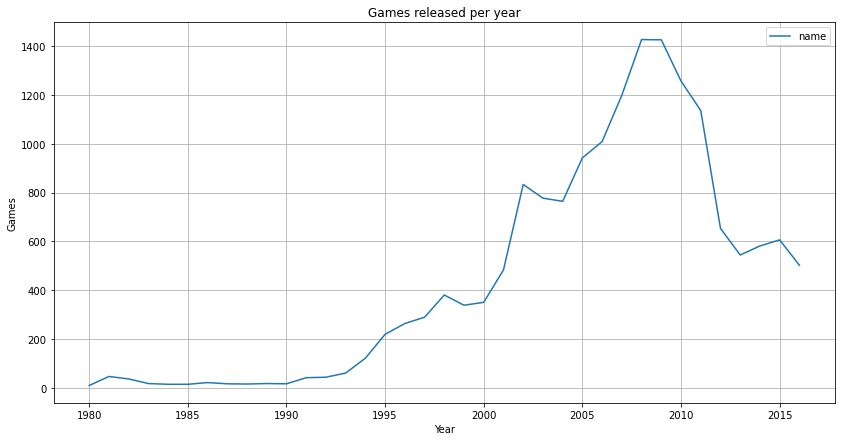

In [19]:
plot = games_pivot_by_year.plot(figsize=(14,7), legend=True, grid=True, title='Games released per year')
plot.set_xlabel('Year'), plot.set_ylabel('Games')
print()

Количество выпускаемых игр очень быстро росла в период с 1992 по 2008 год. На пике в год выпускалось 1427 игр. В последнии 5 лет выпускается около 550-650 игр в год.

#### Рассматриваю как менялись продажи по платформам

In [20]:
games_pivot_by_platform = games.pivot_table(index = 'platform', values = 'ttl_sales', aggfunc = 'sum')
top_5_platforms = games_pivot_by_platform.sort_values(by = 'ttl_sales', ascending = False).head(5)
print('Top 5 platforms global')
display(top_5_platforms)

Top 5 platforms global


,ttl_sales
platform,
PS2,1247.28
X360,961.88
PS3,931.34
Wii,892.37
DS,802.79


In [21]:
games_pivot_sales_per_year_by_platform = games.pivot_table(index = 'year_of_release', columns = 'platform', 
                                                           values = 'ttl_sales', aggfunc = 'sum')
plot_table = games_pivot_sales_per_year_by_platform[top_5_platforms.index]
print('Таблица для построения графика')
display(plot_table.tail())

Таблица для построения графика


platform,PS2,X360,PS3,Wii,DS
year_of_release,,,,,
2012,NaN,99.74,107.36,21.71,11.01
2013,NaN,88.58,113.25,8.59,1.54
2014,NaN,34.74,47.76,3.75,NaN
2015,NaN,11.96,16.82,1.14,NaN
2016,NaN,1.52,3.60,0.18,NaN


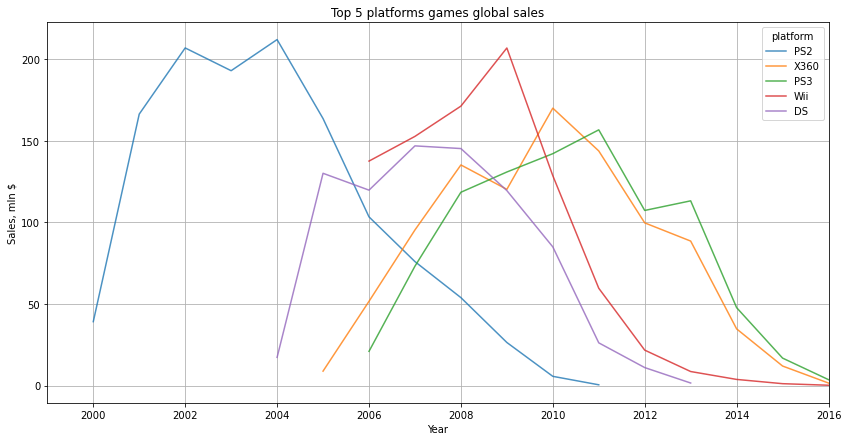

In [22]:
plot = plot_table.plot(figsize=(14,7), legend=True, grid=True, alpha=0.8, 
                  title='Top 5 platforms games global sales', xlim=(1999,2016))
plot.set_xlabel('Year'), plot.set_ylabel('Sales, mln $')
print()

In [23]:
games_pivot_by_platform = games.pivot_table(index = 'platform', values = 'year_of_release', aggfunc = ['min', 'max'])

games_pivot_by_platform['platform_years'] = games_pivot_by_platform[('max', 'year_of_release')] - games_pivot_by_platform[('min', 'year_of_release')]
display(games_pivot_by_platform.sort_values(by = 'platform_years', ascending = False).head())
platform_years = games_pivot_by_platform['platform_years'].mean()
print(f'Среднее время существования платформы: {platform_years:.1f} лет')

,min,max,platform_years
,year_of_release,year_of_release,
platform,,,
PC,1985,2016,31
DS,1985,2013,28
GB,1988,2001,13
X360,2005,2016,11
PSP,2004,2015,11


Среднее время существования платформы: 7.6 лет


Построено распределение по 5 платформам с наибольшими продажами игр для них. Среднее время существования платформы: 7.6 лет.

#### Отбрасываю неактуальные года

В связи с тем, что средний цикл жизни платформы составляет 7,6 лет, а также мы планируем рекламную кампанию на 2017 год, считаю что уместно отбросить часть данных, тк многие платформы уже неактуальны и нужно взять акутуальные предпочтения целевой аудитории. Поэтому в дальнейшем сконцентрируюсь на анализе продаж последних 6 лет (2010-2016 года).

In [24]:
games_sample = games[games['year_of_release'] >= 2010].reset_index()
games_sample['platform'].unique()

array(['X360', 'PS3', 'DS', 'PS4', '3DS', 'Wii', 'XOne', 'WiiU', 'PC',
       'PSP', 'PSV', 'PS2'], dtype=object)

In [25]:
games_pivot_by_platform = games_sample.pivot_table(index = 'platform', values = 'ttl_sales', aggfunc = 'sum')
platforms = games_pivot_by_platform.sort_values(by = 'ttl_sales', ascending = False)
print('Sales by platforms 2010-2016')
display(platforms)

Sales by platforms 2010-2016


,ttl_sales
platform,
PS3,587.74
X360,550.46
PS4,314.14
3DS,257.81
Wii,223.69
XOne,159.32
DS,123.75
PC,121.96
WiiU,82.19


In [26]:
games_pivot_sales_per_year_by_platform = games_sample.pivot_table(index = 'year_of_release', columns = 'platform', 
                                                           values = 'ttl_sales', aggfunc = 'sum')
plot_table = games_pivot_sales_per_year_by_platform[platforms.index]
print('Таблица для построения графика')
display(plot_table)

Таблица для построения графика


platform,PS3,X360,PS4,3DS,Wii,XOne,DS,PC,WiiU,PSP,PSV,PS2
year_of_release,,,,,,,,,,,,
2010,142.17,170.08,NaN,NaN,128.67,NaN,85.02,24.28,NaN,35.04,NaN,5.64
2011,156.78,143.84,NaN,63.20,59.65,NaN,26.18,35.03,NaN,17.82,4.63,0.45
2012,107.36,99.74,NaN,51.36,21.71,NaN,11.01,23.22,17.56,7.69,16.19,NaN
2013,113.25,88.58,25.99,56.57,8.59,18.96,1.54,12.38,21.65,3.14,10.59,NaN
2014,47.76,34.74,100.00,43.76,3.75,54.07,NaN,13.28,22.03,0.24,11.90,NaN
2015,16.82,11.96,118.90,27.78,1.14,60.14,NaN,8.52,16.35,0.12,6.25,NaN
2016,3.60,1.52,69.25,15.14,0.18,26.15,NaN,5.25,4.60,NaN,4.25,NaN


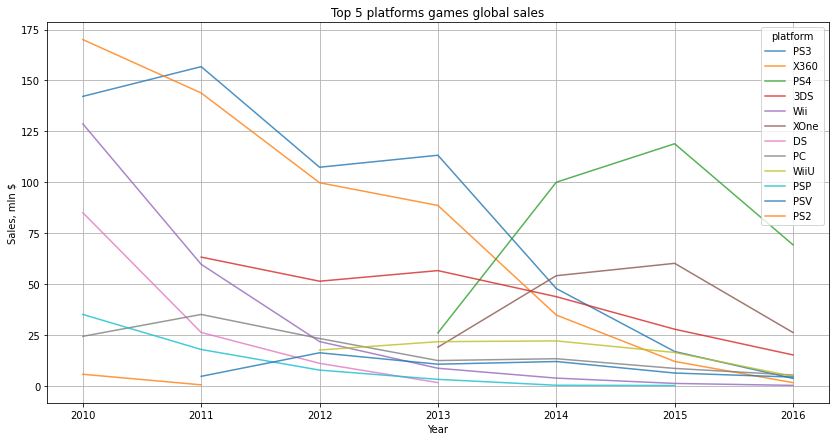

In [27]:
plot = plot_table.plot(figsize=(14,7), legend=True, grid=True, alpha=0.8, 
                  title='Top 5 platforms games global sales')
plot.set_xlabel('Year'), plot.set_ylabel('Sales, mln $')
print()

In [28]:
for i in [2014, 2015, 2016]:
    pivot = games_sample[games_sample['year_of_release'] == i].pivot_table(index = 'platform', 
                                                           values = 'ttl_sales', aggfunc = 'sum')
    print(i)
    display(pivot.sort_values(by = 'ttl_sales', ascending = False))

2014


,ttl_sales
platform,
PS4,100.00
XOne,54.07
PS3,47.76
3DS,43.76
X360,34.74
WiiU,22.03
PC,13.28
PSV,11.90
Wii,3.75


2015


,ttl_sales
platform,
PS4,118.90
XOne,60.14
3DS,27.78
PS3,16.82
WiiU,16.35
X360,11.96
PC,8.52
PSV,6.25
Wii,1.14


2016


,ttl_sales
platform,
PS4,69.25
XOne,26.15
3DS,15.14
PC,5.25
WiiU,4.60
PSV,4.25
PS3,3.60
X360,1.52
Wii,0.18


Лидеры по продажам за последние годы: PS4, XOne и 3DS. Учитывая то, что мы пока имеем неполные данные за 2016 год, продажи по платформам PS4 и XOne находятся в росте, а продажи 3DS постепенно падают, по графику заметно, что платформа теряет популярность. В качестве самых интересных для рекламной компании платформ, останавливаюсь на PS4 и XOne.

#### Выбираю топ 3 платформы

Сконцентрируемся на анализе трех самых популярных платформ за последние годы:

In [29]:
games_sample2 = games_sample[(games_sample['platform'] == 'PS4') | (games_sample['platform'] == 'XOne') | 
                             (games_sample['platform'] == '3DS')].reset_index()

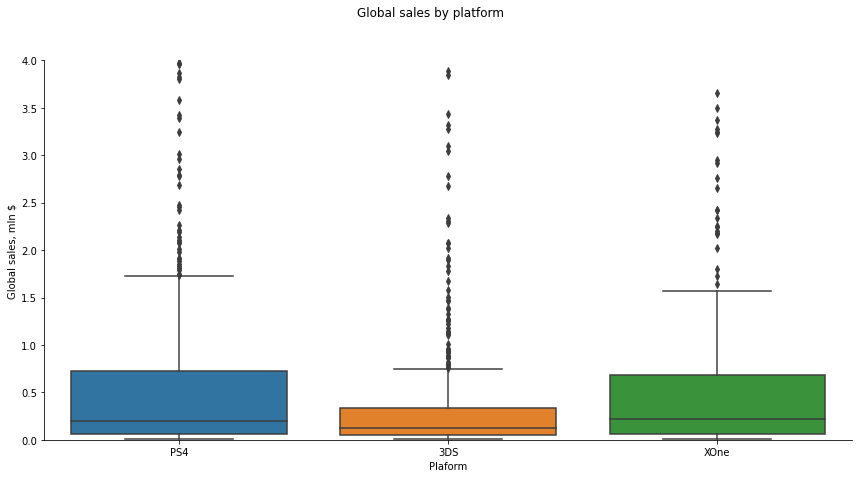

In [30]:
plot = sns.catplot(data=games_sample2, x='platform', y='ttl_sales', kind='box', height=6, 
                    aspect=2, legend_out=False)
plot.set(ylim=(0, 4))
plot.set_axis_labels(x_var='Plaform', y_var='Global sales, mln $')

plot.fig.suptitle('Global sales by platform', y=1.1)
print()

In [31]:
v1 = games_sample2[games_sample2['platform'] == 'PS4']['ttl_sales'].describe()
v2 = games_sample2[games_sample2['platform'] == 'XOne']['ttl_sales'].describe()
v3 = games_sample2[games_sample2['platform'] == '3DS']['ttl_sales'].describe()
v1_list, v2_list, v3_list = [], [], []

for i in v1:
    v1_list.append(round(i,2))
for i in v2:
    v2_list.append(round(i,2))
for i in v3:
    v3_list.append(round(i,2))

stats = pd.DataFrame(['count', 'mean', 'std', 'min', '25%', '50%', '75%', 'max'])
stats.columns = ['Stats']
stats['PS4'] = v1_list
stats['XOne'] = v2_list
stats['3DS'] = v3_list

stats

,Stats,PS4,XOne,3DS
0,count,392.00,247.00,512.00
1,mean,0.80,0.65,0.50
2,std,1.61,1.04,1.44
3,min,0.01,0.01,0.01
4,25%,0.06,0.06,0.05
5,50%,0.20,0.22,0.12
6,75%,0.73,0.69,0.33
7,max,14.63,7.39,14.60


Средние продажи одной игры на платформе PS4 за последние 3 года, составляют 0.8 млн. дол., что на 23% больше чем аналогичный показатель для XOne (0.64) и на 60% больше чем 3DS (0.5). При этом максимальные показатели для PS4 и 3DS достигали 14.6 млн. дол.

#### Оцениваю как влияют на продажи внутри платформ отзывы пользователей и критиков

In [32]:
games_sample2_ps4 = games_sample2[(games_sample2['platform'] == 'PS4')][['ttl_sales', 'critic_score', 'user_score',
       'rating']]
games_sample2_ps4_corr = games_sample2_ps4.corr()

print('PS4 correlation')
display(games_sample2_ps4_corr)

PS4 correlation


,ttl_sales,critic_score,user_score
ttl_sales,1.000000,0.406568,-0.031957
critic_score,0.406568,1.000000,0.557654
user_score,-0.031957,0.557654,1.000000


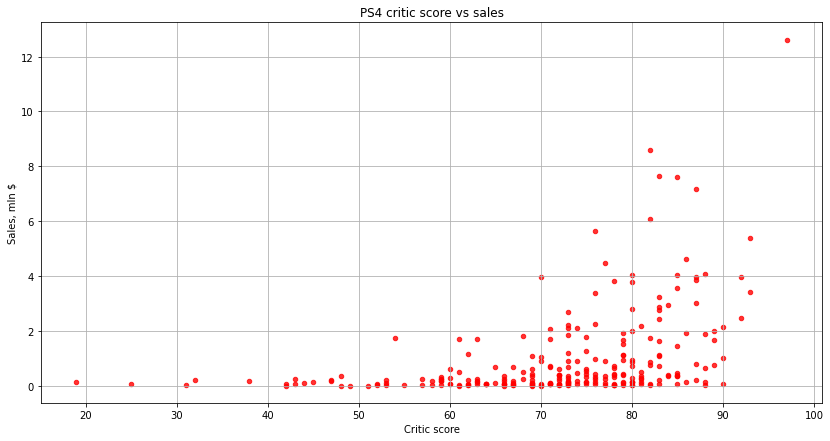

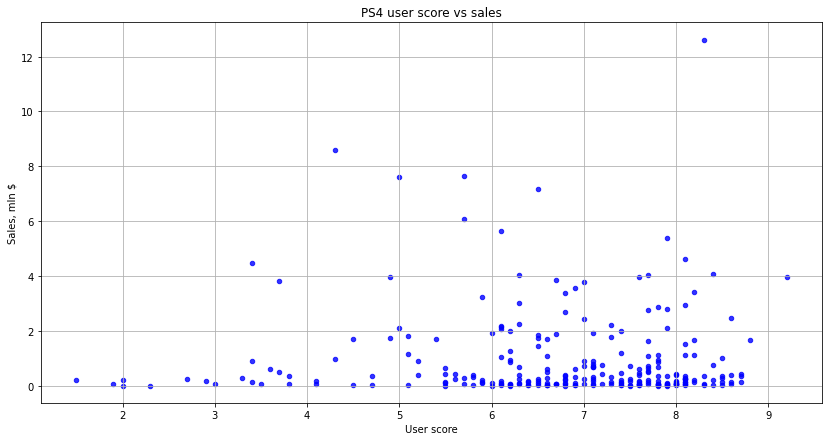

In [33]:
plot1 = games_sample2_ps4.plot(kind = 'scatter', x='critic_score', y='ttl_sales', figsize=(14,7), legend=True, grid=True, 
                             alpha=0.8, title='PS4 critic score vs sales', color='red')
plot2 = games_sample2_ps4.plot(kind = 'scatter', x='user_score', y='ttl_sales', figsize=(14,7), legend=True, grid=True, 
                             alpha=0.8, title='PS4 user score vs sales', color='blue')
plot1.set_xlabel('Critic score'), plot1.set_ylabel('Sales, mln $')
plot2.set_xlabel('User score'), plot2.set_ylabel('Sales, mln $')
print()

In [34]:
games_sample2_xone = games_sample2[(games_sample2['platform'] == 'XOne')][['ttl_sales', 'critic_score', 'user_score',
       'rating']]
games_sample2_xone_corr = games_sample2_xone.corr()

print('XOne correlation')
display(games_sample2_xone_corr)

XOne correlation


,ttl_sales,critic_score,user_score
ttl_sales,1.000000,0.416998,-0.068925
critic_score,0.416998,1.000000,0.472462
user_score,-0.068925,0.472462,1.000000


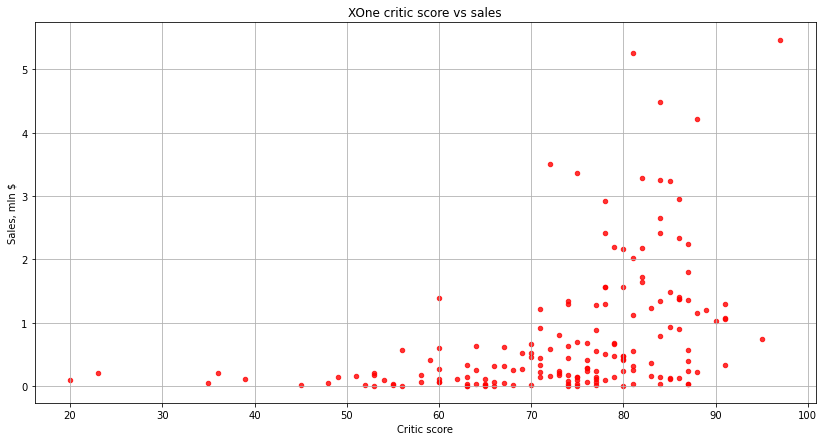

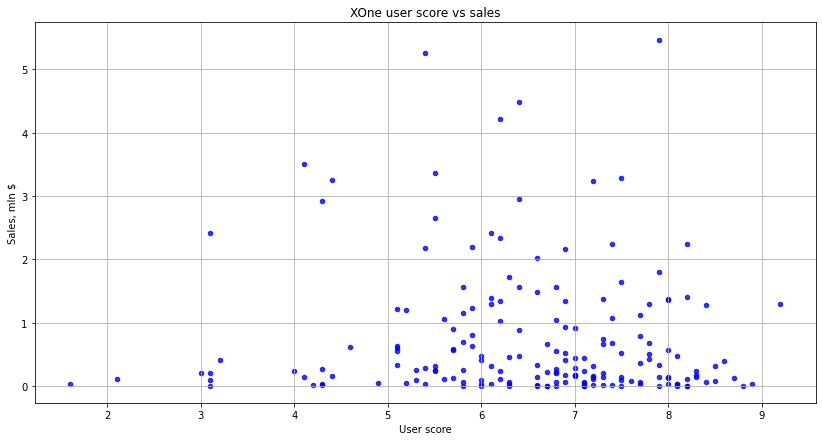

In [35]:
plot1 = games_sample2_xone.plot(kind = 'scatter', x='critic_score', y='ttl_sales', figsize=(14,7), legend=True, grid=True, 
                             alpha=0.8, title='XOne critic score vs sales', color='red')
plot2 = games_sample2_xone.plot(kind = 'scatter', x='user_score', y='ttl_sales', figsize=(14,7), legend=True, grid=True, 
                             alpha=0.8, title='XOne user score vs sales', color='blue')
plot1.set_xlabel('Critic score'), plot1.set_ylabel('Sales, mln $')
plot2.set_xlabel('User score'), plot2.set_ylabel('Sales, mln $')
print()

In [36]:
games_sample2_3ds = games_sample2[(games_sample2['platform'] == '3DS')][['ttl_sales', 'critic_score', 'user_score',
       'rating']]
games_sample2_3ds_corr = games_sample2_3ds.corr()

print('3DS correlation')
display(games_sample2_3ds_corr)

3DS correlation


,ttl_sales,critic_score,user_score
ttl_sales,1.000000,0.348740,0.222078
critic_score,0.348740,1.000000,0.745222
user_score,0.222078,0.745222,1.000000


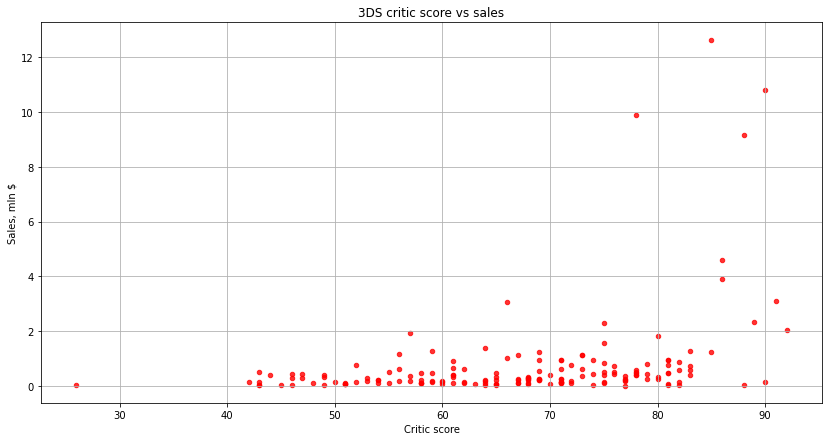

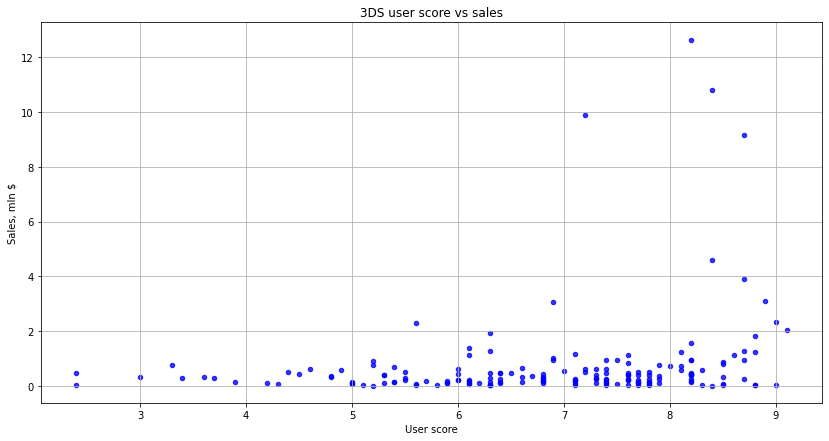

In [37]:
plot1 = games_sample2_3ds.plot(kind = 'scatter', x='critic_score', y='ttl_sales', figsize=(14,7), legend=True, grid=True, 
                             alpha=0.8, title='3DS critic score vs sales', color='red')
plot2 = games_sample2_3ds.plot(kind = 'scatter', x='user_score', y='ttl_sales', figsize=(14,7), legend=True, grid=True, 
                             alpha=0.8, title='3DS user score vs sales', color='blue')
plot1.set_xlabel('Critic score'), plot1.set_ylabel('Sales, mln $')
plot2.set_xlabel('User score'), plot2.set_ylabel('Sales, mln $')
print()

У платформ PS4 и XOne наблюдается корреляция между продажами и оценками критиков, корреляция положительная и составляет 0,4. Сильнее всего она проявляется после отметок свыше 60. Корреляция между продажами и оценками пользователей по этим платформам отсутствует. 
Немного другая картина по платформе 3DS: корреляция между отзывами критиков и продажами составляет 0.35, а корреляция между отзывами пользователей и продажами составляет 0.22. 

#### Рассматриваю продажи в разрезе жанров

In [38]:
games_sample2_genre_pivot = games_sample2.pivot_table(index = 'genre', values = 'ttl_sales', aggfunc = ['sum', 'count'])
games_sample2_genre_pivot.columns = ['sales', 'games']
games_sample2_genre_pivot['sales_per_game'] = games_sample2_genre_pivot['sales'] / games_sample2_genre_pivot['games']
print('Sales by genre')
display(games_sample2_genre_pivot.sort_values(by = 'sales', ascending = False))

Sales by genre


,sales,games,sales_per_game
genre,,,
Action,191.25,416,0.459736
Shooter,150.11,85,1.766000
Role-Playing,123.74,152,0.814079
Sports,88.50,109,0.811927
Platform,41.15,45,0.914444
Racing,36.80,49,0.751020
Simulation,28.88,39,0.740513
Misc,26.61,93,0.286129
Fighting,21.66,39,0.555385


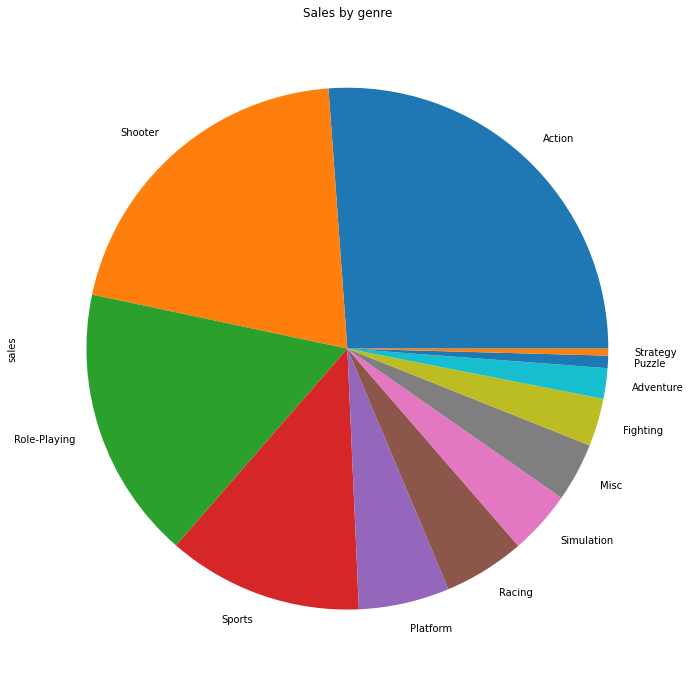

In [39]:
g1 = games_sample2_genre_pivot.sort_values(by = 'sales', ascending = False)
plot2 = g1.plot(kind = 'pie', y='sales', figsize=(12,12), title = 'Sales by genre', legend=False)

Лидерами по общим продажам являются жанры Action, shooter и role-playing.
Наименее низкие продажи и продажи с каждой игры по жанрам strategy, puzzle и adventure. Средние продажи за игру по этим жанрам ниже, чем у лидирующего жанра shooter в 9 раз.

## Составляю портрет пользователя каждого региона (NA, EU, JP)

- Самые популярные платформы;
- Самые популярные жанры;
- Влияние рейтинга ESRB.

#### В разрезе платформ

In [40]:
games_sample_region_platform_pivot = (games_sample[games_sample['year_of_release'] >= 2013]
                                      .pivot_table(index = 'platform', values =['na_sales', 'eu_sales', 'jp_sales'],
                                                             aggfunc = 'sum'))
print('Sales by platform')
games_sample_region_platform_pivot

Sales by platform


,eu_sales,jp_sales,na_sales
platform,,,
3DS,30.96,67.81,38.20
DS,0.85,0.00,0.57
PC,25.36,0.00,11.11
PS3,67.81,23.35,63.50
PS4,141.09,15.96,108.74
PSP,0.17,3.29,0.00
PSV,6.10,18.59,5.04
Wii,5.93,0.05,6.56
WiiU,19.85,10.88,29.21


In [41]:
platforms_na = games_sample_region_platform_pivot['na_sales'].sort_values(ascending = False).head(5)
platforms_na = pd.DataFrame(platforms_na)
platforms_na['%'] = platforms_na['na_sales'] / platforms_na['na_sales'].sum()
print('NA top 5 platforms')
display(platforms_na)

NA top 5 platforms


,na_sales,%
platform,,
PS4,108.74,0.282280
XOne,93.12,0.241732
X360,81.66,0.211983
PS3,63.50,0.164841
3DS,38.20,0.099164


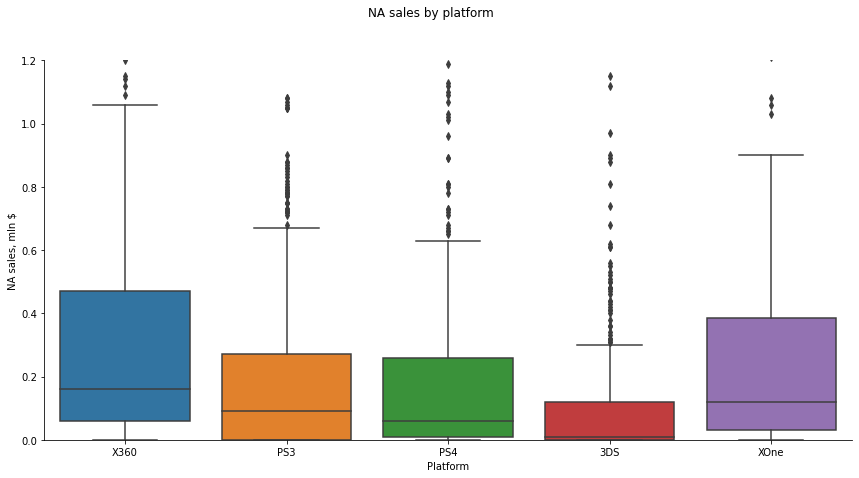

In [42]:
data = games_sample[games_sample['platform'].isin(platforms_na.index)][['platform','na_sales']]
plot = sns.catplot(data=data, x='platform', y='na_sales', kind='box', height=6, 
                    aspect=2, legend_out=False)
plot.set(ylim=(0, 1.2))
plot.set_axis_labels(x_var='Platform', y_var='NA sales, mln $')

plot.fig.suptitle('NA sales by platform', y=1.1)
print()

In [43]:
platforms_eu = games_sample_region_platform_pivot['eu_sales'].sort_values(ascending = False).head(5)
platforms_eu = pd.DataFrame(platforms_eu)
platforms_eu['%'] = platforms_eu['eu_sales'] / platforms_eu['eu_sales'].sum()
print('EU top 5 platforms')
display(platforms_eu)

EU top 5 platforms


,eu_sales,%
platform,,
PS4,141.09,0.422463
PS3,67.81,0.203042
XOne,51.59,0.154475
X360,42.52,0.127317
3DS,30.96,0.092703


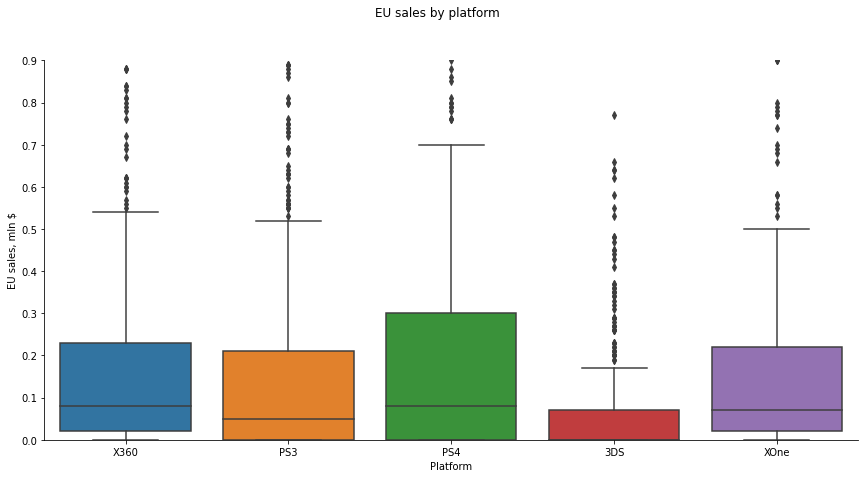

In [44]:
data = games_sample[games_sample['platform'].isin(platforms_eu.index)][['platform','eu_sales']]
plot = sns.catplot(data=data, x='platform', y='eu_sales', kind='box', height=6, 
                    aspect=2, legend_out=False)
plot.set(ylim=(0, 0.9))
plot.set_axis_labels(x_var='Platform', y_var='EU sales, mln $')

plot.fig.suptitle('EU sales by platform', y=1.1)
print()

In [45]:
platforms_jp = games_sample_region_platform_pivot['jp_sales'].sort_values(ascending = False).head(5)
platforms_jp = pd.DataFrame(platforms_jp)
platforms_jp['%'] = platforms_jp['jp_sales'] / platforms_jp['jp_sales'].sum()
print('JP top 5 platforms')
platforms_jp

JP top 5 platforms


,jp_sales,%
platform,,
3DS,67.81,0.496449
PS3,23.35,0.170950
PSV,18.59,0.136101
PS4,15.96,0.116846
WiiU,10.88,0.079654


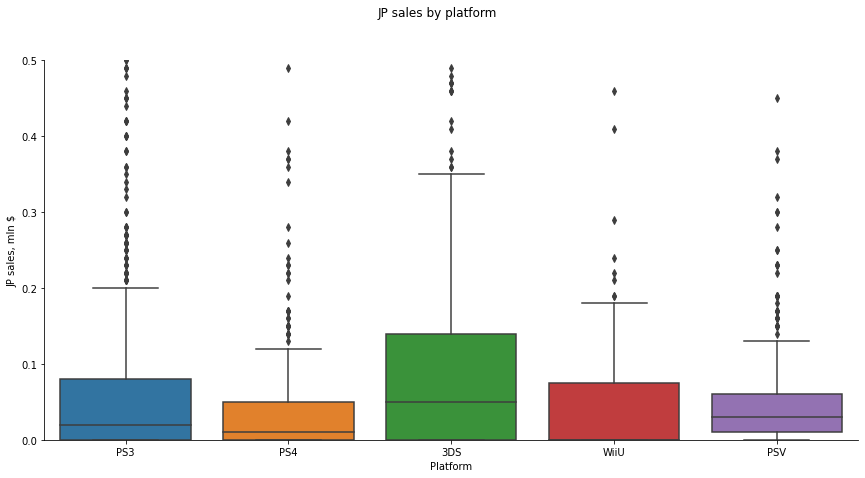

In [46]:
data = games_sample[games_sample['platform'].isin(platforms_jp.index)][['platform','jp_sales']]
plot = sns.catplot(data=data, x='platform', y='jp_sales', kind='box', height=6, 
                    aspect=2, legend_out=False)
plot.set(ylim=(0, 0.5))
plot.set_axis_labels(x_var='Platform', y_var='JP sales, mln $')

plot.fig.suptitle('JP sales by platform', y=1.1)
print()

#### В разрезе жанров

In [47]:
games_sample_region_genres_pivot = (games_sample
                                      .pivot_table(index = 'genre', values =['na_sales', 'eu_sales', 'jp_sales'],
                                                             aggfunc = 'sum'))
print('Sales by genre')
display(games_sample_region_genres_pivot)

Sales by genre


,eu_sales,jp_sales,na_sales
genre,,,
Action,233.63,72.20,290.64
Adventure,18.88,15.67,20.84
Fighting,20.33,13.90,39.05
Misc,66.09,24.29,123.80
Platform,38.30,15.81,54.90
Puzzle,6.58,3.40,9.10
Racing,54.79,6.68,46.11
Role-Playing,75.48,103.54,112.05
Shooter,171.45,14.04,237.47


In [48]:
genres_na = games_sample_region_genres_pivot['na_sales'].sort_values(ascending = False).head(5)
genres_na = pd.DataFrame(genres_na)
genres_na['%'] = genres_na['na_sales'] / genres_na['na_sales'].sum()
print('NA by genre')
display(genres_na)

NA by genre


,na_sales,%
genre,,
Action,290.64,0.315416
Shooter,237.47,0.257713
Sports,157.49,0.170915
Misc,123.80,0.134353
Role-Playing,112.05,0.121602


In [49]:
genres_eu = games_sample_region_genres_pivot['eu_sales'].sort_values(ascending = False).head(5)
genres_eu = pd.DataFrame(genres_eu)
genres_eu['%'] = genres_eu['eu_sales'] / genres_eu['eu_sales'].sum()
print('EU by genre')
display(genres_eu)

EU by genre


,eu_sales,%
genre,,
Action,233.63,0.352123
Shooter,171.45,0.258406
Sports,116.84,0.176099
Role-Playing,75.48,0.113762
Misc,66.09,0.099610


In [50]:
genres_jp = games_sample_region_genres_pivot['jp_sales'].sort_values(ascending = False).head(5)
genres_jp = pd.DataFrame(genres_jp)
genres_jp['%'] = genres_jp['jp_sales'] / genres_jp['jp_sales'].sum()
print('JP by genre')
display(genres_jp)

JP by genre


,jp_sales,%
genre,,
Role-Playing,103.54,0.447238
Action,72.20,0.311866
Misc,24.29,0.104920
Platform,15.81,0.068291
Adventure,15.67,0.067686


#### В разрезе рейтинга ESRB

In [51]:
games_sample_region_esrb_pivot = (games_sample
                                      .pivot_table(index = 'rating', values =['na_sales', 'eu_sales', 'jp_sales'],
                                                             aggfunc = 'sum'))
print('Sales by ESRB')
display(games_sample_region_esrb_pivot)

Sales by ESRB


,eu_sales,jp_sales,na_sales
rating,,,
E,197.34,47.87,271.83
E10+,99.28,13.22,159.38
EC,0.00,0.00,1.13
M,292.04,30.45,382.22
RP,0.03,0.00,0.00
T,113.08,42.11,160.81


In [52]:
esrb_na = games_sample_region_esrb_pivot['na_sales'].sort_values(ascending = False).head(5)
esrb_na = pd.DataFrame(esrb_na)
esrb_na['%'] = esrb_na['na_sales'] / esrb_na['na_sales'].sum()
print('NA by ESRB')
display(esrb_na)

NA by ESRB


,na_sales,%
rating,,
M,382.22,0.391872
E,271.83,0.278694
T,160.81,0.164871
E10+,159.38,0.163405
EC,1.13,0.001159


In [53]:
esrb_eu = games_sample_region_esrb_pivot['eu_sales'].sort_values(ascending = False).head(5)
esrb_eu = pd.DataFrame(esrb_eu)
esrb_eu['%'] = esrb_eu['eu_sales'] / esrb_eu['eu_sales'].sum()
print('EU by ESRB')
display(esrb_eu)

EU by ESRB


,eu_sales,%
rating,,
M,292.04,0.416148
E,197.34,0.281203
T,113.08,0.161135
E10+,99.28,0.141471
RP,0.03,0.000043


In [54]:
esrb_jp = games_sample_region_esrb_pivot['jp_sales'].sort_values(ascending = False).head(5)
esrb_jp = pd.DataFrame(esrb_jp)
esrb_jp['%'] = esrb_jp['jp_sales'] / esrb_jp['jp_sales'].sum()
print('JP by ESRB')
display(esrb_jp)

JP by ESRB


,jp_sales,%
rating,,
E,47.87,0.358174
T,42.11,0.315077
M,30.45,0.227834
E10+,13.22,0.098915
RP,0.00,0.000000


In [55]:
esrb_dict = {'E' : 1, 'M' : 2, 'E10+' : 3, 'T' : 4, 'EC' : 5, 'RP' : 6}
def esrb_to_scale(row):
    esrb = row['rating']
    if esrb in esrb_dict:
        return esrb_dict[esrb]
    else:
        return esrb

,na_sales,eu_sales,jp_sales,esrb
na_sales,1.000000,0.770061,0.254359,-0.081447
eu_sales,0.770061,1.000000,0.282091,-0.090725
jp_sales,0.254359,0.282091,1.000000,-0.015038
esrb,-0.081447,-0.090725,-0.015038,1.000000


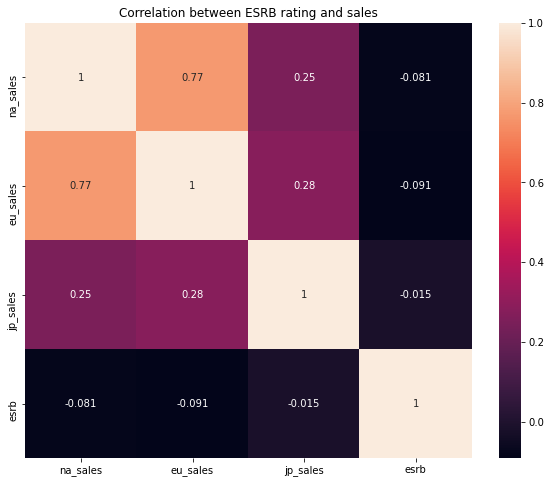

In [56]:
warnings.filterwarnings(action='ignore')
games_sample_esrb = games_sample[['na_sales', 'eu_sales', 'jp_sales','rating']]
games_sample_esrb['esrb'] = games_sample_esrb.apply(esrb_to_scale, axis = 1)
games_sample_esrb_corr = games_sample_esrb.corr()

display(games_sample_esrb_corr)
plt.figure(figsize=(10, 8))
plot = sns.heatmap(games_sample_esrb_corr, annot=True)
plot.set_title('Correlation between ESRB rating and sales')
print()
warnings.filterwarnings(action='default')

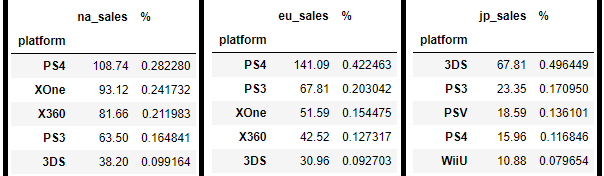

В Европе лидирует PS4 (42% всех продаж), на втором месте PS3 (20% всех продаж). В Северной Америке также лидирует PS4 (28% от всех продаж), но не с таким сильным отрывом как в Европе. На второй строчке с отставанием в 4% следует XOne. В обоих регионах в топ5 попала лишь одна портативная приставка (3DS) на 5ое место с долей в продажах равной 10%. В Японии абсолютным лидером является платформа 3DS: продажи игр для нее занимают 50% всех продаж. На втором месте с большим отрывом идет PS3 (17% всех продаж).

Большим отличием Японии от Северной Америки и Европы, является сильное предпочтение портативных игровых платформ, в сумме они занимают 63% (3DS и PSV) всех продаж. Также отличительной чертой является, что Япония не торопится обновлять PS3 до PS4, в отличие от Европы и Северной Америки.

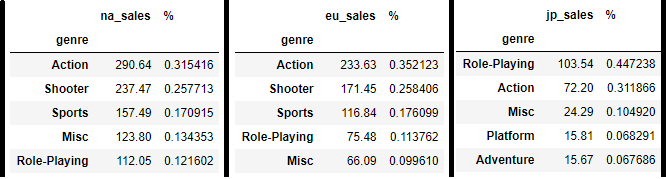

В Северной Америке и Европе очень похожая ситуация с продажами по жанрам: первые 3 строчки занимают жанры action, shooter и sport (33%, 26% и 17% соответственно). В Японии абсолютным лидером является жанр role-playing (44% всех продаж), затем жанр action (33%) и на 3ей строчке жанр misc (10%).

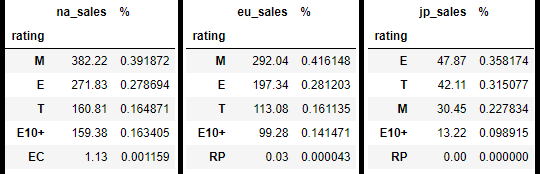

В Северной Америке и Европе очень похожая ситуация с продажами по рейтингу ESRB: первые 3 строчки занимают M (mature), E (everyone) и T (teen) (40%, 28% и 16% соответственно). В Японии первые 3 строчки занимают E (everyone), T (teen) и M (mature)  (36%, 31% и 22% соответственно). Корреляция между продажами и рейтингом esrb близка к нулю по всем регионам.

## Проверяю гипотезы
- Средние пользовательские рейтинги платформ Xbox One и PC одинаковые;
- Средние пользовательские рейтинги жанров Action и Sports разные.

In [57]:
print('H0: Средние пользовательские рейтинги платформы Xbox One  == Средние пользовательские рейтинги платформы PC')
print('H1: Средние пользовательские рейтинги платформы Xbox One  != Средние пользовательские рейтинги платформы PC')
print('Выборки независимы, поэтому использую метод ttest_ind')

H0: Средние пользовательские рейтинги платформы Xbox One  == Средние пользовательские рейтинги платформы PC
H1: Средние пользовательские рейтинги платформы Xbox One  != Средние пользовательские рейтинги платформы PC
Выборки независимы, поэтому использую метод ttest_ind


In [58]:
xone_user_score = games_sample[games_sample['platform'] == 'XOne']['user_score'].dropna()
pc_user_score = games_sample[games_sample['platform'] == 'PC']['user_score'].dropna()

In [59]:
print('H0: Дисперсия d1 == Дисперсия d2')
print('H1: Дисперсия d1 != Дисперсия d2')

d1 = xone_user_score.describe()[2]**2
d2 = pc_user_score.describe()[2]**2
df1 = len(xone_user_score) - 1 
df2 = len(pc_user_score) - 1

alpha = 0.05

results = st.f.sf(d1/d2, df1, df2)

print('p-значение:', results)

if (results < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")
    
print('Использую equal_var = True')

H0: Дисперсия d1 == Дисперсия d2
H1: Дисперсия d1 != Дисперсия d2
p-значение: 0.9719686760402857
Не получилось отвергнуть нулевую гипотезу
Использую equal_var = True


In [60]:
alpha = 0.05

results = st.ttest_ind(list(xone_user_score), list(pc_user_score))

print('p-значение:', results.pvalue)

if (results.pvalue < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение: 0.980998110649032
Не получилось отвергнуть нулевую гипотезу


____

In [61]:
print('H0: Средние пользовательские рейтинги жанра Action  == Средние пользовательские рейтинги жанра Sports')
print('H1: Средние пользовательские рейтинги жанра Action != Средние пользовательские рейтинги жанра Sports')
print('Выборки независимы, поэтому использую метод ttest_ind')

H0: Средние пользовательские рейтинги жанра Action  == Средние пользовательские рейтинги жанра Sports
H1: Средние пользовательские рейтинги жанра Action != Средние пользовательские рейтинги жанра Sports
Выборки независимы, поэтому использую метод ttest_ind


In [62]:
action_user_score = games_sample[games_sample['genre'] == 'Action']['user_score'].dropna()
sports_user_score = games_sample[games_sample['genre'] == 'Sports']['user_score'].dropna()

In [63]:
print('H0: Дисперсия d1 == Дисперсия d2')
print('H1: Дисперсия d1 != Дисперсия d2')

d1 = action_user_score.describe()[2]**2
d2 = sports_user_score.describe()[2]**2
df1 = len(action_user_score) - 1 
df2 = len(sports_user_score) - 1

alpha = 0.05

results = st.f.sf(d1/d2, df1, df2)

print('p-значение:', results)

if (results < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")
    
print('Использую equal_var = True')

H0: Дисперсия d1 == Дисперсия d2
H1: Дисперсия d1 != Дисперсия d2
p-значение: 0.9999981242201413
Не получилось отвергнуть нулевую гипотезу
Использую equal_var = True


In [64]:
alpha = 0.01

results = st.ttest_ind(list(action_user_score), list(sports_user_score))

print('p-значение:', results.pvalue)

if (results.pvalue < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение: 6.057466966671628e-19
Отвергаем нулевую гипотезу


##### Гипотеза 1:
- Средние пользовательские рейтинги платформ Xbox One и PC одинаковые;

H0: Средние пользовательские рейтинги платформы Xbox One  == Средние пользовательские рейтинги платформы PC

H1: Средние пользовательские рейтинги платформы Xbox One  != Средние пользовательские рейтинги платформы PC

Выборки независимы, поэтому использую метод ttest_ind

Не получилось отвергнуть нулевую гипотезу равенства дисперсий, поэтому буду использовать equal_var = True

p-значение: 0.980998110649032; Не получилось отвергнуть нулевую гипотезу о равенстве средних пользовательских рейтингов двух платформ.

##### Гипотеза 2:
- Средние пользовательские рейтинги жанров Action (англ. «действие», экшен-игры) и Sports (англ. «спортивные соревнования») разные;

H0: Средние пользовательские рейтинги жанра Action  == Средние пользовательские рейтинги жанра Sports

H1: Средние пользовательские рейтинги жанра Action != Средние пользовательские рейтинги жанра Sports

Выборки независимы, поэтому использую метод ttest_ind

Не получилось отвергнуть нулевую гипотезу равенства дисперсий, поэтому буду использовать equal_var = True

p-значение: 6.057466966671628e-19; Нулевая гипотеза о равенстве средних пользовательских рейтингов двух жанров отвергнута

### Вывод

В ходе исследования продаж компьютерных игр были изучены полученные данные, проведен исследовательский анализ продаж в разрезе платформ, жанров и регионов, а также проверены две гипотезы.

В связи с тем, что платформы меняются и их среднее время существования составляет 7.6 лет, для анализа продаж по платформам был выбран период 2013-2016 год, а для анализа остальных разрезов был взят период 2010-2016 года.

Между регионами (Северная Америка, Европа и Япония), наблюдаются некоторые различия в предочтениях при выборе платформы, жанра игры и рейтинга ERSB. Более подробно эти различия описаны выше в проекте, поэтому здесь приведу лишь финальные таблицы:

<h4><center>Предочтения по платформам в зависимости от региона</center></h4>

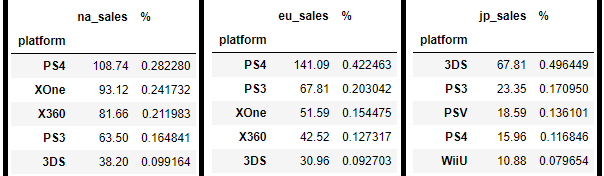

<h4><center>Предочтения по жанрам в зависимости от региона</center></h4>

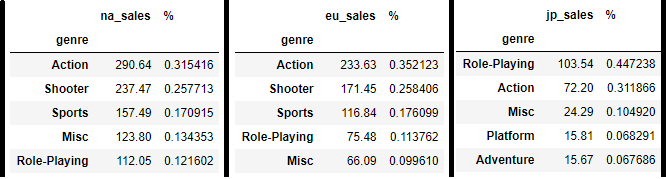

<h4><center>Предочтения по рейтингу ESRB в зависимости от региона</center></h4>

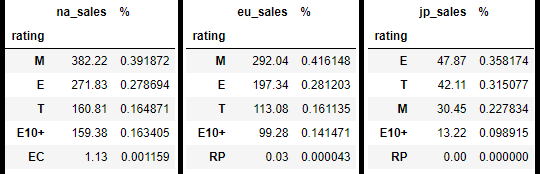

В связи с этими различиями, продукт для рекламной кампании рекомендуется выбирать индивидуально для каждого региона из следующих категорий:

- Северная Америка

Платформа: PS4/XOne; Жанр: Action/Shooter; ESRB Rating: M/E

- Европа

Платформа: PS4; Жанр: Action; ESRB Rating: M/E

- Япония

Платформа: 3DS; Жанр: Role-Playing; ESRB Rating: E/T

Списки актуальных игр для каждого региона, исходя из различий озвученных выше:

In [65]:
na_recommendation_list = (games
                          .query('platform == ["PS4", "XOne"] & year_of_release == 2016 & genre == ["Action",  "Shooter"]')
                          .sort_values(by='na_sales', ascending=False))
print('NA recomedation list')
display(na_recommendation_list.head(10))

NA recomedation list


,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,ttl_sales
171,Uncharted 4: A Thief's End,PS4,2016,Shooter,1.85,2.50,0.19,0.85,93.0,7.9,T,5.39
245,Call of Duty: Infinite Warfare,PS4,2016,Shooter,1.61,2.00,0.15,0.71,77.0,3.4,M,4.47
640,Call of Duty: Infinite Warfare,XOne,2016,Shooter,1.46,0.74,0.00,0.22,78.0,3.1,M,2.42
325,Tom Clancy's The Division,PS4,2016,Shooter,1.35,1.70,0.15,0.60,80.0,7.0,M,3.80
758,Tom Clancy's The Division,XOne,2016,Shooter,1.29,0.68,0.00,0.20,80.0,6.9,M,2.17
709,Battlefield 1,XOne,2016,Shooter,1.28,0.77,0.00,0.20,87.0,8.2,M,2.25
289,Battlefield 1,PS4,2016,Shooter,1.10,2.15,0.21,0.61,88.0,8.4,M,4.07
767,Overwatch,PS4,2016,Shooter,0.81,0.85,0.15,0.33,90.0,6.1,T,2.14
1439,Gears of War 4,XOne,2016,Shooter,0.78,0.44,0.00,0.12,84.0,6.2,M,1.34
2332,MLB 16: The Show,PS4,2016,Action,0.72,0.00,0.00,0.17,NaN,NaN,NaN,0.89


In [66]:
eu_recommendation_list = (games
                          .query('platform == "PS4" & year_of_release == 2016 & genre == ["Action",  "Shooter"]')
                          .sort_values(by='eu_sales', ascending=False))
print('EU recomedation list')
display(eu_recommendation_list.head(10))

EU recomedation list


,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,ttl_sales
171,Uncharted 4: A Thief's End,PS4,2016,Shooter,1.85,2.50,0.19,0.85,93.0,7.9,T,5.39
289,Battlefield 1,PS4,2016,Shooter,1.10,2.15,0.21,0.61,88.0,8.4,M,4.07
245,Call of Duty: Infinite Warfare,PS4,2016,Shooter,1.61,2.00,0.15,0.71,77.0,3.4,M,4.47
325,Tom Clancy's The Division,PS4,2016,Shooter,1.35,1.70,0.15,0.60,80.0,7.0,M,3.80
708,Far Cry: Primal,PS4,2016,Action,0.60,1.25,0.06,0.35,76.0,6.3,M,2.26
968,Mafia III,PS4,2016,Action,0.42,1.08,0.03,0.28,68.0,5.1,M,1.81
767,Overwatch,PS4,2016,Shooter,0.81,0.85,0.15,0.33,90.0,6.1,T,2.14
1056,No Man's Sky,PS4,2016,Action,0.63,0.76,0.03,0.27,71.0,4.5,T,1.69
1275,Doom (2016),PS4,2016,Shooter,0.54,0.69,0.02,0.24,NaN,NaN,NaN,1.49
1806,Watch Dogs 2,PS4,2016,Action,0.37,0.58,0.00,0.18,83.0,7.8,M,1.13


In [67]:
jp_recommendation_list = (games
                          .query('platform == "3DS" & year_of_release == 2016 & genre == ["Role-Playing",  "Action"]')
                          .sort_values(by='jp_sales', ascending=False))
print('JP recomedation list')
display(jp_recommendation_list.head(10))

JP recomedation list


,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,ttl_sales
108,Pokemon Sun/Moon,3DS,2016,Role-Playing,2.98,1.45,2.26,0.45,NaN,NaN,NaN,7.14
1466,Yokai Watch 3,3DS,2016,Action,0.00,0.00,1.33,0.00,NaN,NaN,NaN,1.33
3177,Dragon Quest Monsters Joker 3,3DS,2016,Role-Playing,0.00,0.00,0.63,0.00,NaN,NaN,NaN,0.63
3593,Yokai Sangokushi,3DS,2016,Action,0.00,0.00,0.56,0.00,NaN,NaN,NaN,0.56
2219,Kirby: Planet Robobot,3DS,2016,Action,0.28,0.14,0.47,0.04,81.0,8.7,E,0.93
6162,Monster Hunter Stories,3DS,2016,Action,0.00,0.00,0.28,0.00,NaN,NaN,NaN,0.28
3788,Mario & Sonic at the Rio 2016 Olympic Games,3DS,2016,Action,0.05,0.21,0.25,0.02,NaN,NaN,NaN,0.53
7121,Puzzle & Dragons X: God Chapter / Dragon Chapter,3DS,2016,Action,0.00,0.00,0.22,0.00,NaN,NaN,NaN,0.22
7371,Dragon Ball: Fusions,3DS,2016,Role-Playing,0.02,0.00,0.19,0.00,68.0,7.6,T,0.21
7747,Shin Megami Tensei IV: Final,3DS,2016,Role-Playing,0.05,0.00,0.14,0.01,NaN,NaN,NaN,0.20
